# Phase 1 Project

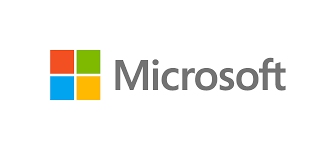

## Overview

## Business Problem

Microsoft has decided to open a new branch of their company: Microsoft Movie Studios. In order to aid the new head of Microsoft Movie Studios in making decisions regarding what type of films to create, I explore and analyze data from two sources: IMDb and Box Office Mojo. In doing so, I look at the ratings and lengths of various films, genres, production studios, and gross earnings.

## Data Understanding

In [1]:
#Importing neccesary packages
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
import plotly.express as px

In [2]:
#Loading in data from imdb file
conn = sqlite3.Connection('zippedData/im.db')

imdb_tables = """
SELECT name FROM sqlite_master WHERE type='table'
"""
pd.read_sql(imdb_tables, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [3]:
#Loading in data from the movie_gross file taken from Box Office Mojo
movie_gross_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

### IMDb Data

#### Movie_Basics Table

In [4]:
#Looking at the number of rows (146144) and columns (6)
movie_basics_df = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

In [5]:
#Looking at the general structure and content of the movie_basics table from the IMDb file
movie_basics_df.info()

#6 columns and 146,144 rows with missing values in 'original_title', 'runtime_minutes', and 'genres'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [6]:
#Looking at the descriptive statistics for the numerical columns start_year and and runtime_minutes
movie_basics_df.describe()

#We see here that in the runtime_minutes column, both the min and max are outliers 
#with values of 1 and 51,420, respectively

#Furthermore, when disregarding the outliers, the range of movie runtimes is quite small 
#with the 25% quartile being 70 minutes and the 75% quartile being 99 minutes

#We also see that the max in the start_year column is an outlier as it is 2115 
#and suggests that we should analyze the column start_years in more depth

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [7]:
#Looking at how many movies were released in each year
pd.read_sql("""
    SELECT COUNT(*) AS num_movies_per_year, start_year
    FROM movie_basics
    GROUP BY start_year;""", conn)

#This dataframe shows that some movies that have not been released yet (2023 and onward) are included in this dataset

#Therefore, in our data preparation, we will create a new table that includes 
#Only the movies that have already been released

,num_movies_per_year,start_year
0,11849,2010
1,12900,2011
2,13787,2012
3,14709,2013
4,15589,2014
5,16243,2015
6,17272,2016
7,17504,2017
8,16849,2018
9,8379,2019


In [8]:
#Looking at the average movie runtime in minutes per year
movie_basics_df.groupby('start_year').mean()

#This dataframe shows the mean runtime in minutes per year
#As we can see, length of movies have increased over time

#Furthermore, this dataframe confirms that we should remove the years 2023 - 2115 when we clean our data

,runtime_minutes
start_year,
2010,85.495694
2011,86.410106
2012,89.208856
2013,84.931670
2014,84.541500
2015,85.407108
2016,84.974249
2017,85.732214
2018,87.661099


In [9]:
#Looking at how many movies fall under specific genre categories (ex: how many movies are from the Drama genre)
#pd.read_sql("""
    #SELECT COUNT(*) AS num_movies_per_genre, genres
    #FROM movie_basics
    #GROUP BY genres
    #ORDER BY num_movies_per_genre DESC;""", conn).head(5)

#As we can see from this dateframe, the top five genres in this dataset are Documentary, Drama, Comedy, None, and Horror

#Due to the fact that 5408 entries are lacking a genre specification, we need to assess if these entries will provide
#us with insightful information or we will remove them

#### Movie_Ratings Table

In [10]:
#Exploring the movie_ratings table from the imbd data
movie_ratings_df = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
movie_ratings_df.info()

#3 columns and 73,856 rows with no missing data in any column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [11]:
movie_ratings_df

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [12]:
#Deactivating scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#Looking at the descriptive statistics for the numerical columns averagerating and numvotes
movie_ratings_df.describe()

#From this dateframe, we can see that the column numvotes has an outlier of 1,841,066 as its max

,averagerating,numvotes
count,73856.00000,73856.00000
mean,6.33273,3523.66217
std,1.47498,30294.02297
min,1.00000,5.00000
25%,5.50000,14.00000
50%,6.50000,49.00000
75%,7.40000,282.00000
max,10.00000,1841066.00000


In [13]:
#Looking at how many ratings there are of each average rating (ex: how many movies were given a 7.0 rating)
#pd.read_sql("""
    #SELECT COUNT(averagerating) AS num_of_avgratings, averagerating
    #FROM movie_ratings
    #GROUP BY averagerating
    #ORDER BY COUNT(averagerating) DESC;""", conn)

#This data shows us that the most common rating is a 7.0 and the least common rating is a 9.9

#### Directors Table

In [14]:
#Exploring the directors table from the imbd data
directors_df = pd.read_sql("""SELECT * FROM directors;""", conn)
directors_df.info()

#2 columns (movie_id and people_id) with 291174 rows and no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


#### Persons Table

In [15]:
#Exploring the persons table from the imbd data
persons_df = pd.read_sql("""SELECT * FROM persons;""", conn)
persons_df.info()

#5 columns with 606648 rows and missing values in 'birth_year', 'death_year', and 'primary_profession'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


#### Known_For Table

In [16]:
#Exploring the known_for table from the imbd data
#known_for_df = pd.read_sql("""SELECT * FROM known_for;""", conn)
#known_for_df.info()

#2 columns (movie_id and people_id) with 1638260 rows and no missing values

#### Principals Table

In [17]:
#Exploring the known_for table from the imbd data
principals_df = pd.read_sql("""SELECT * FROM principals;""", conn)
principals_df.info()

#6 columns with 1028186 rows and missing values in 'job' and 'characters'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


### Movie Gross Data


In [18]:
#Looking at the general information and structure of the movie_gross data
movie_gross_df.info()

#From this, we see that the movie_gross dataset has 3387 rows and 5 columns, 
#and the columns with missing data are studio, domestic_gross, and foreign gross

#It is interesting that, unlike domestic_gross, foreign_gross is listed as the datatype object 
#meaning that either all of the values are strings or there is a mix of datatypes

#We will want to convert all the data from foreign_gross to floats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [19]:
#After looking more thoroughly at the data in foreign_gross, 
#we can see that some values are strings and other values are floats

#In order to change all the values in foreign_gross to floats, we need to drop all the NaN values from ALL the columns
#rather than just the foreign_gross column
#Doing so will allow us to maintain a sense of consistency across all columns

movie_gross_df.dropna(inplace = True)

movie_gross_df.info()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [20]:
#Converting the datatype of all values to strings for uniformity
movie_gross_df['foreign_gross']= movie_gross_df['foreign_gross'].apply(lambda x: str(x))
#Removing any puncuation in the strings (commas) 
movie_gross_df['foreign_gross']= movie_gross_df['foreign_gross'].apply(lambda x: x.replace(',',''))
#Changing the datatype of all values to float
movie_gross_df['foreign_gross']=movie_gross_df['foreign_gross'].apply(lambda x: float(x))

movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            2007 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 94.1+ KB


In [21]:
#Looking at the descriptive statistics of the numerical columns domestic gross, foreign gross, and year
movie_gross_df.describe()

,domestic_gross,foreign_gross,year
count,2007.00000,2007.00000,2007.00000
mean,47019840.20179,75790384.84131,2013.50623
std,81626889.32324,138179552.62752,2.59800
min,400.00000,600.00000,2010.00000
25%,670000.00000,3900000.00000,2011.00000
50%,16700000.00000,19400000.00000,2013.00000
75%,56050000.00000,75950000.00000,2016.00000
max,936700000.00000,960500000.00000,2018.00000


## Data Preparation

### Creating and Cleaning the Joined_MB_MR DataFrame

In [22]:
#Joining the movie_ratings and movie_basics tables to access more data about the movies
joined_mb_mr = pd.read_sql("""
    SELECT * 
    FROM movie_basics as mb
    JOIN movie_ratings as mr
        USING (movie_id)
    ;""", conn)

In [23]:
#Exploring the new dataframe
joined_mb_mr.info()


#After the join, we have 73,856 rows and 9 columns

#The only columns with any missing values are 'runtime_minutes' and 'genres'

#The number of missing values in both of these columns has decreased significantly after the join

#The missing values in 'genre' dropped from 5408 missing values out of 146,144 in movie_basics 
#to 804 missing values out of 73,856 in this new dataframe

#The missing values in 'runtime_minutes' dropped from 31,739 missing values out of 146,144 in movie_basics
#to 7,620 mission valoues out of 73,856 in this new dataframe

#IMPORTANT: This data only shows movies from 2010 until 2019

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [24]:
#Taking out missing data from joined_mb_mr dataset

#As mentioned above, there are two columns with missing values: 'runtime_minutes' and 'genres'.

#Because it is difficult to replace genres and replacing missing runtime_minutes values with the median 
#would likley create an inaccurate image of the data, I will drop all missing values

joined_mb_mr = joined_mb_mr.dropna()
joined_mb_mr

#Now there are 65720 rows and 8 columns

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"Action,Crime,Drama",7.00000,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,"Biography,Drama",7.20000,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00000,Drama,6.90000,4517
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00000,"Comedy,Drama,Fantasy",6.50000,119
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.00000,"Adventure,Animation,Comedy",8.10000,263
...,...,...,...,...,...,...,...,...
73849,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.00000,Drama,8.40000,365
73850,tt9913056,Swarm Season,Swarm Season,2019,86.00000,Documentary,6.20000,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00000,Documentary,6.20000,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,"Drama,Family",8.70000,136


In [25]:
#Making genres column into list of multiple genres
joined_mb_mr['genres'] = joined_mb_mr['genres'].apply(lambda x: x.split(','))

In [26]:
#Creating a new column called genres1 that shows the first genre of each movie
joined_mb_mr['genres1'] = joined_mb_mr['genres'].apply(lambda x: x[0])

### Cleaning the Movie Gross Dataset

In [27]:
#Adding a total revenue column which is the dometic gross and foreign gross combined
movie_gross_df['total_revenue'] =  movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']

### New DataFrame: Average Rating Per Genre

In [28]:
#2010 - 2019
#Creating a new dataframe that shows the average rating per genre
avg_ratings_per_genre = joined_mb_mr.groupby('genres1')['averagerating'].mean().sort_values(ascending = False)
avg_ratings_per_genre = pd.DataFrame(avg_ratings_per_genre)

In [29]:
#Adding the number of movies per genre
num_movies_per_genre = joined_mb_mr.groupby('genres1')['movie_id'].count()
avg_ratings_per_genre['num_movies_per_genre'] = num_movies_per_genre

In [30]:
#Adding the number of ratings per genre
avg_ratings_per_genre['numvotes'] = joined_mb_mr.groupby('genres1')['numvotes'].sum()

In [31]:
#Limiting the results to only genres with more than 1000 movies
avg_ratings_per_genre_filtered = avg_ratings_per_genre.loc[avg_ratings_per_genre['num_movies_per_genre'] > 1000]\
.sort_values(by = 'averagerating',ascending = False)

In [32]:
#Cleaning up column names
avg_ratings_per_genre_filtered = avg_ratings_per_genre_filtered.rename(columns = {'averagerating': 'Average_Rating',
                                                                                  'numvotes': 'Num_Ratings',
                                                                     'num_movies_per_genre': 'Num_Movies_Per_Genre'})


avg_ratings_per_genre_filtered = avg_ratings_per_genre_filtered.rename_axis('Genre')

#62135 ENTRIES

### New DataFrame: Average Revenue Per Genre

In [33]:
#2010 - 2018
#Creating a new dataframe called average_revenue_per_genre 
#by merging the joined_mb_mr dataframe and movie_gross_df dataframe
average_revenue_per_genre = pd.merge(joined_mb_mr, movie_gross_df, left_on = 'primary_title', right_on = 'title')

#Dropping the duplicate titles
average_revenue_per_genre = average_revenue_per_genre.drop_duplicates('primary_title')

#Dropping the redundant duplicate title column
average_revenue_per_genre = average_revenue_per_genre.drop(labels = 'title', axis = 1)

#Dropping start_year and keeping the year column
average_revenue_per_genre = average_revenue_per_genre.drop(labels = 'start_year', axis = 1)

In [34]:
#Creating a new filtered dataframe that only includes total revenue, domestic gross, and foreign gross
average_revenue_per_genre_filtered = pd.DataFrame(average_revenue_per_genre.groupby
                                                  ('genres1')[['total_revenue', 'domestic_gross', 'foreign_gross']]
                                                  .mean())
#Sorting the dataframe by total revenue in descending order
average_revenue_per_genre_filtered.sort_values(by = 'total_revenue', ascending = False)

#1541 ENTRIES

,total_revenue,domestic_gross,foreign_gross
genres1,,,
Adventure,259229229.24390,88691779.85976,170537449.38415
Action,239887632.91780,85275345.89461,154612287.02319
Mystery,146039999.80000,68240000.00000,77799999.80000
Animation,135456995.23810,43484709.52381,91972285.71429
Horror,91135173.68421,42920942.10526,48214231.57895
Thriller,73542066.66667,11509700.00000,62032366.66667
Biography,69677140.93701,31864381.88189,37812759.05512
Comedy,66801044.19817,33357659.14329,33443385.05488
Crime,56846305.86765,25768716.17647,31077589.69118


### New DataFrame: Runtime Per Rating Score

In [35]:
#Creating a new dataframe called runtime_per_rating
runtime_per_rating = pd.DataFrame(joined_mb_mr)

In [36]:
#Creating 'Rating' categories on a Good, Average, or Bad scale

#If the averagerating of a movie is greater than or equal to 7, it is considered 'Good'
runtime_per_rating.loc[runtime_per_rating['averagerating'] >= 7, 'Rating'] = 'Good'

#If the averagerating of a movie is less than 7 and greater than or equal to 5, it is considered 'Average'
runtime_per_rating.loc[(runtime_per_rating['averagerating'] < 7) & \
                        (runtime_per_rating['averagerating'] >= 5), 'Rating'] = 'Average'

#If the averagerating of a movie is less than 5, it is considered 'Bad'
runtime_per_rating.loc[runtime_per_rating['averagerating']  < 5, 'Rating'] = 'Bad'

In [37]:
#Limiting the entries to just those whose runtime is between 1 hour and 4 hours
runtime_per_rating_filtered = runtime_per_rating.loc[(runtime_per_rating['runtime_minutes'] <= 240) \
                                                     & (runtime_per_rating['runtime_minutes'] > 60)]\
                                                        .sort_values(by = 'runtime_minutes',ascending = False)

In [38]:
#Looking at the runtime of all genres of movies across the different ratings categories
runtime_per_rating_all_genres = runtime_per_rating_filtered.groupby('Rating').mean()
runtime_per_rating_all_genres

#61244 ENTRIES

,start_year,runtime_minutes,averagerating,numvotes
Rating,,,,
Average,2014.20066,97.30589,6.06985,3795.30828
Bad,2014.22280,93.83044,3.92875,858.07201
Good,2014.45723,96.49493,7.73021,6599.48345


In [39]:
#Looking at the runtime for Action movies across the different ratings categories
runtime_per_rating_action = runtime_per_rating_filtered.loc[runtime_per_rating_filtered['genres1'] == 'Action']\
                                                                                        .groupby('Rating').mean()
runtime_per_rating_action

#6055 ENTRIES

,start_year,runtime_minutes,averagerating,numvotes
Rating,,,,
Average,2014.28726,107.87626,5.97492,15895.36885
Bad,2014.19472,99.49795,3.84962,1610.96129
Good,2014.49350,108.90824,7.61828,36948.09899


In [40]:
#Looking at the runtime for Adventure movies across the different ratings categories
runtime_per_rating_adventure = runtime_per_rating_filtered.loc[runtime_per_rating_filtered['genres1'] == 'Adventure']\
                                                                                        .groupby('Rating').mean()
runtime_per_rating_adventure

#2855 ENTRIES

,start_year,runtime_minutes,averagerating,numvotes
Rating,,,,
Average,2014.25962,93.67950,6.06168,8469.77261
Bad,2014.22888,91.88011,4.01553,1789.38965
Good,2014.22472,93.90762,7.73633,21115.57928


### New DataFrame: Directors of the Most Successful Movies

In [41]:
#Creating new dataset that merges directors_df and persons_df from the imdb data
#which will eventually merge with average_revenue_per_genre

#Merging directors_df with persons_df
director_info = pd.merge(directors_df, persons_df, left_on = 'person_id', right_on = 'person_id')

#Dropping the columns birth_year and death_year because they are not relevant to our analysis
director_info = director_info.drop('birth_year', axis = 1)
director_info = director_info.drop('death_year', axis = 1)

#Merging director_info with average_revenue_per_genre
most_successful = pd.merge(director_info, average_revenue_per_genre,\
                           left_on = 'movie_id', right_on = 'movie_id')

#Dropping duplicate movie ids
most_successful = most_successful.drop_duplicates('movie_id')

#Dropping more columns that are not relevant to our analysis
most_successful = most_successful.drop(columns = ['original_title', 'genres', 'numvotes'])
#1541 ENTRIES

In [42]:
#Making a dataframe of the directors with the highest mean revenue in 2010-2018
most_successful_avg_rev = most_successful.groupby('primary_name')['total_revenue']\
                                            .mean().sort_values(ascending = False).head(15)

most_successful_avg_rev = most_successful_avg_rev.to_frame()
most_successful_avg_rev = most_successful_avg_rev.reset_index()

#Making a dataframe of the directors with the highest revenue from a single movie in 2010-2018
most_successful_single_rev = most_successful[['primary_name','primary_title','year','total_revenue',]]\
                            .sort_values(by = 'total_revenue', ascending = False).head(15)

#Creating a list of directors that appear in both of the above dataframes
best_directors = []
for x in most_successful_avg_rev['primary_name']:
    if x in most_successful_single_rev['primary_name'].values:
            best_directors.append(x)

### New DataFrame: Actors and Actresses from the Most Successful Movies

In [43]:
#Creating new dataset that merges principals_df and persons_df from the imdb data
#which will eventually merge with average_revenue_per_genre
actors = pd.merge(principals_df, persons_df, left_on = 'person_id', right_on = 'person_id')
actors = pd.merge(actors, average_revenue_per_genre,\
                           left_on = 'movie_id', right_on = 'movie_id')

#Dropping duplicate movie ids
actors = actors.drop_duplicates('movie_id')

#Dropping columns that are not relevant to our analysis
actors = actors.drop(columns = ['original_title', 'genres', 'numvotes', 'job', 'ordering', 
                                'birth_year', 'death_year', 'primary_profession', 'runtime_minutes'])

#Editing the dataframe so that it only shows entries for people who are actors/actresses
actors = actors.loc[(actors['category'] == 'actor')|(actors['category'] == 'actress')]

In [44]:
#Making a dataframe of the actors/actresses from movies with the highest mean revenue in 2010-2018
best_actors_avg_rev = actors.groupby('primary_name')['total_revenue']\
                                            .mean().sort_values(ascending = False).head(15)
best_actors_avg_rev = best_actors_avg_rev.to_frame()
best_actors_avg_rev = best_actors_avg_rev.reset_index()

#Making a dataframe of the actors/actresses from movies with the highest revenue from a single movie in 2010-2018
best_actors_single_rev = actors[['primary_name','primary_title','year','total_revenue',]]\
                            .sort_values(by = 'total_revenue', ascending = False).head(15)

#Creating a list of directors that appear in both of the above dataframes
best_actors = []
for x in best_actors_avg_rev['primary_name']:
    if x in best_actors_single_rev ['primary_name'].values:
            best_actors.append(x)

In [45]:
#c = joined_mb_mr.groupby('start_year').count()
#sns.barplot(c.index, c['movie_id'])

In [46]:
#sns.scatterplot(joined_mb_mr['numvotes'], joined_mb_mr['runtime_minutes'])

In [48]:
#b = avg_ratings_per_genre_filtered.sort_values(by = 'Num_Movies_Per_Genre',  ascending = False)
#sns.barplot(x = b.index, y = b['Num_Movies_Per_Genre'])